<a href="https://colab.research.google.com/github/Zauralochka/ML-ZoomCamp/blob/main/HW4_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'

In [4]:
!wget $data

--2022-10-03 09:08:10--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.01s   

2022-10-03 09:08:10 (5.51 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [5]:
df = pd.read_csv('AER_credit_card_data.csv')

In [6]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [8]:
df.shape

(1319, 12)

In [10]:
df.isna().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

## Code the target column

In [12]:
df.card = (df.card == 'yes').astype(int)

In [13]:
df.card.iloc[:10]

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: card, dtype: int64

## Split the data set

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['card'].values
y_val = df_val['card'].values
y_test = df_test['card'].values

del df_train['card']
del df_val['card']
del df_test['card']

## Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the card variable.
Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* `reports`
* `dependents`
* `active`
* `share`

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [19]:
numerical = ['reports', 'dependents', 'active', 'share']

for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    print('%10s, %.3f' % (col, auc))

   reports, 0.717
dependents, 0.533
    active, 0.604
     share, 0.989


__Answer:__ The highest AUC score has the column `share`

Training the model
From now on, use these columns only:

["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [21]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [20]:
selected_columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"] 


In [22]:
# apply one-hot-encoding
train_dict = df_train[selected_columns].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [23]:
#train model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.615
* 0.515
* 0.715
* 0.995

In [24]:
val_dict = df_val[selected_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [25]:
auc = roc_auc_score(y_val, y_pred)
print(auc.round(3))

0.995


__Answer:__ 0.995

## Question 3
Now let's compute precision and recall for our model.

Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8

In [30]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.fn)

    return df_scores

In [31]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)

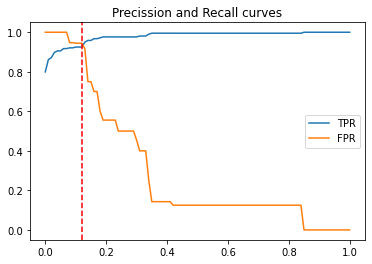

In [52]:
plt.plot(df_scores.threshold, df_scores.tpr, label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, label='FPR')
plt.legend()
plt.title('Precission and Recall curves')
plt.axvline(x=0.12, color='red', linestyle='--')
plt.show()

__Answer:__  approximatelly 0.1

## Question 4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing :

 

Where  is precision and  is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

* 0.1
* 0.4
* 0.6
* 0.7

F1 =2* P * R /(P + R) 

In [54]:
df_scores['f1'] = 2 * df_scores['tpr'] * df_scores['fpr'] / (df_scores['tpr'] + df_scores['fpr'])

In [56]:
df_scores['f1']

0      0.888421
1      0.925439
2      0.931567
3      0.946188
4      0.950450
         ...   
96     0.000000
97     0.000000
98     0.000000
99     0.000000
100    0.000000
Name: f1, Length: 101, dtype: float64

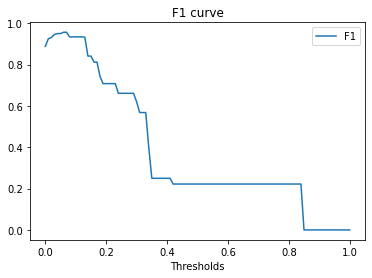

In [57]:
plt.plot(df_scores.threshold, df_scores.f1, label='F1')
plt.title('F1 curve')
plt.xlabel('Thresholds')
plt.legend()
plt.show()

__Answer:__ 0.01

## Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard devidation of the AUC scores across different folds?

* 0.003
* 0.014
* 0.09
* 0.24

## Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 1, 10]
Initialize KFold with the same parameters as previously
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

* 0.01
* 0.1
* 1
* 10
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C